# Advanced autodiff

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams["font.size"] = 12

%config InlineBackend.figure_format = "retina"

## Controlling gradient recording

You can stop recording if you do not want to record some expensive operation:

In [2]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as tape:
    x_sq = x**2
    with tape.stop_recording():
        y_sq = y**2
        
    z = x_sq + y_sq
    
grad = tape.gradient(z, {"x": x, "y": y})

print("dz/dx: ", grad["x"])
print("dz/dy: ", grad["y"])

dz/dx:  tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy:  None


2021-09-10 16:19:43.215484: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You can also stop recording a gradient over some expression:

In [5]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as tape:
    z = x**2 + tf.stop_gradient(y**2)
    
grad = tape.gradient(z, {"x": x, "y": y})

print("dz/dx: ", grad["x"])
print("dz/dy: ", grad["y"])

dz/dx:  tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy:  None


## Multiple tapes

It is possible to use two tapes simultaneously with any inteference between them:

In [6]:
x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
    tape0.watch(x0)
    tape1.watch(x1)
    
    y0 = tf.math.sin(x0)
    y1 = tf.nn.sigmoid(x1)
    
    y = y0 + y1
    
    ys = tf.reduce_sum(y)
    
print("dys/dx0: ", tape0.gradient(ys, x0))
print("dys/dx1: ", tape1.gradient(ys, x1))

dys/dx0:  tf.Tensor(1.0, shape=(), dtype=float32)
dys/dx1:  tf.Tensor(0.25, shape=(), dtype=float32)


## Nested tapes

Compute second-order derivative by using nested tapes:

In [7]:
x = tf.Variable(1.0)

with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        y = x**3
        
    dy_dx = t1.gradient(y, x)
    
d2y_dx2 = t2.gradient(dy_dx, x)

print("dy/dx: ", dy_dx)
print("d2y/dx2: ", d2y_dx2)

dy/dx:  tf.Tensor(3.0, shape=(), dtype=float32)
d2y/dx2:  tf.Tensor(6.0, shape=(), dtype=float32)


Nested tapes can be used to include regularizers into the loss function that are derivatives of the model wrt inputs:

In [11]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape() as t2:
    with tf.GradientTape(watch_accessed_variables=False) as t1:
        t1.watch(x)
        y = layer(x)
        out = tf.reduce_mean(y**2)
    g1 = t1.gradient(out, x)
    g1_norm = tf.norm(g1)
    
dg1_norm_dtheta = t2.gradient(g1_norm, layer.trainable_variables)

In [13]:
print([var.shape for var in dg1_norm_dtheta])

[TensorShape([5, 10]), TensorShape([10])]


## Jacobians

### Scalar source

Jacobian matrix of a vector-valued target with scalar-valued source $\mathbb R^n \to \mathbb R$.

Function `tf.GradientTape.jacobian` allows to compute Jacobian efficiently.
Documentation says that it creates `tf.function` automatically for each call, so for better performance, it makes sense to add `tf.function` yourself, such that it is not created all the time.

First, consider vector-valued function of a scalar argument:

In [4]:
x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
    y = tf.nn.sigmoid(x + delta)
    
dy_dx = tape.jacobian(y, delta)

2021-10-22 21:40:27.680587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


For the Jacobian with scalar source variable, the Jacobian has the same shape as the target variable:

In [5]:
y.shape, dy_dx.shape

(TensorShape([201]), TensorShape([201]))

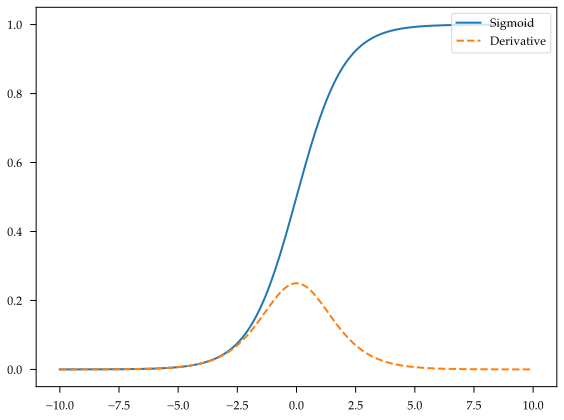

In [6]:
plt.figure()
plt.plot(x, y, "-", label="Sigmoid")
plt.plot(x, dy_dx, "--", label="Derivative")
plt.legend(loc="upper right")
plt.tight_layout()

### Tensor source

When the type of the `sources` variable is `Tensor`, then `jacobian` computes the derivative of each elements of the target with respect to each element of source(s).

In [12]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
    y = layer(x)
    
y.shape

TensorShape([7, 10])

In [13]:
layer.kernel.shape

TensorShape([5, 10])

In [14]:
j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

If we take `gradient` instead of `jacobian`, it would be as if we sum elements of `y` and then take take the derivative:

In [19]:
g = tape.gradient(y, layer.kernel)
print("g.shape: ", g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
diff = tf.reduce_sum(abs(g - j_sum))
assert diff < 1e-4
print("Difference: {:.3e}", diff.numpy())

g.shape:  (5, 10)
Difference: {:.3e} 0.0


#### Example: Hessian

In [20]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
    with tf.GradientTape() as t1:
        x = layer1(x)
        x = layer2(x)
        loss = tf.reduce_mean(x**2)
        
    g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [21]:
print(f"layer.kernel.shape: {layer1.kernel.shape}")
print(f"h.shape: {h.shape}")

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


**Note** To understand, why `h` has four dimensions, although it should be a matrix, think about the following. The loss function depends on a vector of arguments `layer1.kernel`, which is structured here as a matrix. For a function $\mathbb R^n \to \mathbb R$ the Hessian matrix will be of size $n \times n$, hence, this is how `h` has develop four dimensions: it should be of "square" size compared to the input variable.

To use properly the gradient and the Hessian, for example, in Newton's method, you need to flatten both the gradient and the Hessian:

In [22]:
n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

Hessian matrix is a symmetric matrix (for sufficiently smooth functions):

In [23]:
def imshow_zero_center(image, **kwargs):
    lim = tf.reduce_max(abs(image))
    plt.imshow(image, vmin=-lim, vmax=lim, cmap="seismic", **kwargs)
    plt.colorbar()

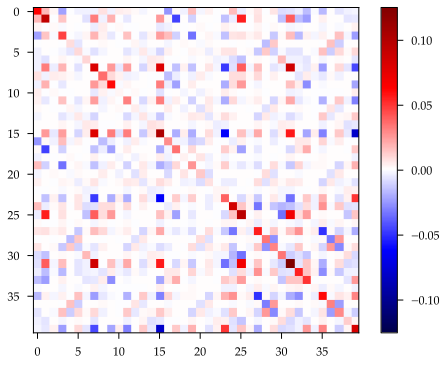

In [24]:
imshow_zero_center(h_mat)

In [25]:
eps = 1e-3
eps_eye = tf.eye(h_mat.shape[0]) * eps

update = tf.linalg.solve(h_mat + eps_eye, g_vec)

# Now you can update the parameters of the layer.
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

### Batch Jacobian

In [38]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
    tape.watch(x)
    y = layer1(x)
    y = layer2(y)
    
y.shape

TensorShape([7, 6])

The full Jacobian will be of dimension 4 with shape `(7, 6, 7, 5)`:

In [39]:
j = tape.jacobian(y, x)
j.shape

TensorShape([7, 6, 7, 5])

If the gradients are independent than slices of these tensor will be diagonal matrices:

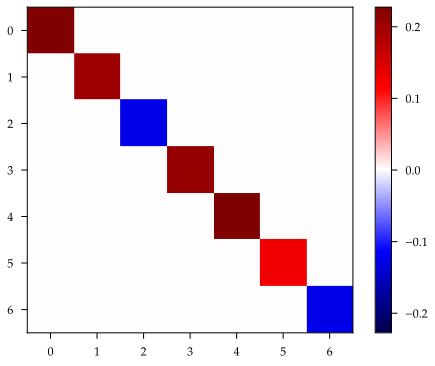

In [40]:
imshow_zero_center(j[:, 0, :, 0])

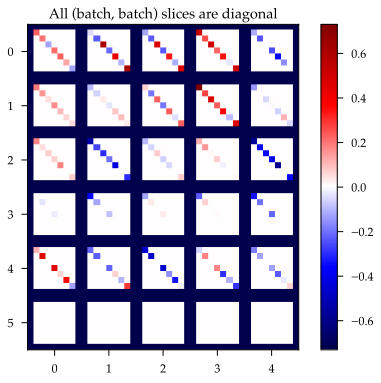

In [42]:
def plot_as_patches(j):
    # Reorder axes so that the diagonals will each form a contigous patch.
    j = tf.transpose(j, [1, 0, 3, 2])
    # Pad in every patch.
    lim = tf.reduce_max(abs(j))
    j = tf.pad(j, [[0, 0], [1, 1], [0, 0], [1, 1]], constant_values=-lim)
    # Reshape to form a single image.
    s = j.shape
    j = tf.reshape(j, (s[0]*s[1], s[2]*s[3]))
    imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])
    
plot_as_patches(j)
_ = plt.title("All (batch, batch) slices are diagonal")
    

To get the desired result, you can sum over the duplicate dimension:

In [43]:
j_sum = tf.reduce_sum(j, axis=2)
print(j_sum.shape)
j_select = tf.einsum("bxby->bxy", j)
print(j_select.shape)

(7, 6, 5)
(7, 6, 5)


To do it more efficiently, `batch_jacobian` can be used:

In [44]:
jb = tape.batch_jacobian(y, x)
jb.shape

TensorShape([7, 6, 5])

In [49]:
error = tf.reduce_max(abs(jb - j_sum))
assert error < 1e-7

In [50]:
print(error.numpy())

0.0


This function should be used with caution as targets can be not independent:

In [68]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
    tape.watch(x)
    y = layer1(x)
    y = bn(y, training=True)
    y = layer2(x)
    
j = tape.jacobian(y, x)
j.shape

TensorShape([7, 6, 7, 5])

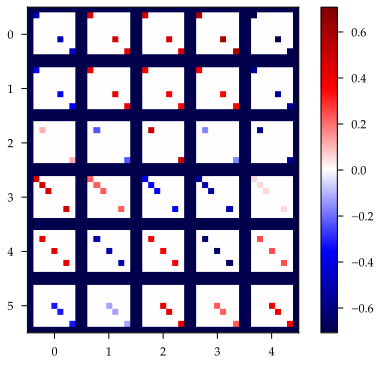

In [69]:
plot_as_patches(j)

Overall, I did not really understand here how to use `batch_jacobian` and what its purpose is.